<a href="https://colab.research.google.com/github/Servat0r/ISPR-Midterms-2023/blob/master/Midterm1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Midterm 1 ISPR 2023 - Assignment 6 - Salvatore Correnti (m. 584136)
In this assignment we will show the implementation and testing on different images of an image blob detector based on the `Laplacian of Gaussian` convolution filter.

## Initial imports
Before coding, we use a single cell for changing working directory to the one in which this notebook is contained and for all the imports for simplyfing reading.

In [ ]:
%cd ./drive/MyDrive/Github/ISPR-Midterms-2023

/content/drive/MyDrive/Github/ISPR-Midterms-2023


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 # for converting BGR -> grayscale
from scipy.signal import convolve2d as scipy_convolve2d # 2d-convolution operator
from scipy.ndimage import gaussian_laplace
from skimage.exposure import rescale_intensity
from PIL import Image
from typing import * # for function signatures

## Definition and Implementation of LoG
We first define the `Laplacian of Gaussian` operator as the sum of the diagonal elements of the Jacobian matrix of the Gaussian function:

$$g_{\sigma}(x, y) := \dfrac{1}{2\pi\sigma^2}e^{-\left(\dfrac{x^2 + y^2}{2\sigma^2}\right)}$$.

$$\nabla g_{\sigma}(x, y) = -\dfrac{g_{\sigma}(x,y)}{\sigma^2}\left[\begin{array}{c} x \\ y \end{array}\right]$$

$$\nabla^2g_{\sigma}(x,y) = \dfrac{\partial^2 g_{\sigma}}{\partial x^2} + \dfrac{\partial^2 g_{\sigma}}{\partial y^2} = \dfrac{e^{-\left(\dfrac{x^2 + y^2}{2\sigma^2}\right)}}{\pi\sigma^4}\left[\dfrac{x^2 + y^2}{2\sigma^2} - 1\right]\:\:(1)$$


As we can see in (1), the sign of $\nabla^2 g_{\sigma}$ is determined by the value of $x^2 + y^2$, which can be interpreted as the radius of a circle centered in $(0, 0)$ to which $(x, y)$ belongs, and in particular $\nabla^2 g_{\sigma}$ when this radius is equal to $\sigma\sqrt{2}$, for which in fact the $\nabla^2 g_{\sigma}$ used as convolutional filter has the maximum response.

Sometimes the Laplacian of Gaussian is used in its `normalized` form:

$$ \nabla^2_{norm}g_{\sigma}(x, y) := \sigma^2\nabla^2g_{\sigma}(x,y)$$

The normalized form has the effect to maintain a higher diversity in pixel values after the convolution.

Since we are operating with discrete values like images, we need to define a `kernel`, which is a matrix $M \in \mathbb{R^{(2n+1) \times (2n+1)}}$ such that $M_{n+1 \pm i, n+1 \pm j} = f(\pm i, \pm j)$ for a given function $f$.

In [ ]:
def log_filter(window_size: int, sigma: float = 1.0, normalized=False):
  """
  :param window_size: Size of the kernel window.
  :param sigma: Variance (sigma) of the LoG filter.
  """
  w1 = h1 = window_size // 2  # In case of odd window, will give 0 to central value
  w2 = h2 = window_size - w1
  x, y = np.arange(-w1, w2, 1), np.arange(-h1, h2, 1)
  mg = np.meshgrid(x, y)
  # Compute the (x^2+y^2/(2sigma^2)) matrix
  r = (np.square(mg[0][:, :]) + np.square(mg[1][:, :]))/(2 * sigma**2)
  # Now compute the exp(r) matrix
  gs = np.exp(-r)
  exponent = 2 if normalized else 4
  result = 1.0/(np.pi * sigma**exponent) * (gs * (r - 1.0)) # * for elementwise product
  return result.astype(np.float32)

We now consider also the `Difference of Gaussian` approximation:

In [ ]:
def gaussian_filter(window_size: int, sigma: float=1.0):
  """
  :param window_size: Size of the kernel window.
  :param sigma: Variance (sigma) of the LoG filter.
  """
  w1 = h1 = window_size // 2  # In case of odd window, will give 0 to central value
  w2 = h2 = window_size - w1
  x, y = np.arange(-w1, w2, 1), np.arange(-h1, h2, 1)
  mg = np.meshgrid(x, y)
  # Compute the (x^2+y^2/(2sigma^2)) matrix
  r = -(np.square(mg[0][:, :]) + np.square(mg[1][:, :]))/(2 * sigma**2)
  # Now compute the exp(r) matrix
  gs = np.exp(r)
  result = 1.0/(2 * np.pi * sigma**2) * gs
  return result.astype(np.float32)

In [ ]:
def dog_filter(window_size: int, sigma0: float = 1.0, kappa: int = 1.0):
  u = gaussian_filter(window_size, (kappa+1)*sigma0)
  v = gaussian_filter(window_size, sigma0)
  return (u - v)/(kappa * sigma0**2)

An example of LoG matrix for a 3x3 kernel (both non-normalized and normalized):

In [ ]:
print("Non-normalized kernel: ")
print(log_filter(3, 2.0))
print("Normalized kernel: ")
print(log_filter(3, 2.0, True))
print("Approximated kernel: ")
print(dog_filter(3, 1.0, 2))

Non-normalized kernel: 
[[-0.01162031 -0.01536213 -0.01162031]
 [-0.01536213 -0.01989437 -0.01536213]
 [-0.01162031 -0.01536213 -0.01162031]]
Normalized kernel: 
[[-0.04648125 -0.06144851 -0.04648125]
 [-0.06144851 -0.07957747 -0.06144851]
 [-0.04648125 -0.06144851 -0.04648125]]
Approximated kernel: 
[[-0.0213628  -0.03990206 -0.0213628 ]
 [-0.03990206 -0.07073553 -0.03990206]
 [-0.0213628  -0.03990206 -0.0213628 ]]


## Dataset
For performing convolutions we will use the following dataset:

http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip

Since its whole dimension is of about 125 MB, (by now) the whole dataset is stored in the same folder of this notebook.

We will now define some utilities for our task:

In [ ]:
def load_image(dir_path: str, file_name: str):
  return Image.open(os.path.join(dir_path, file_name)).convert('L')

def get_image_array(arr: np.ndarray, show=False):
  image = Image.fromarray(arr, mode='L')
  if show:
    image.show()
  return image

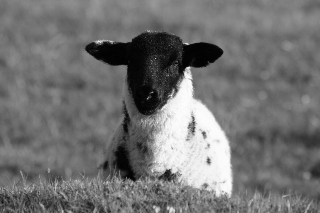

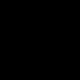

In [ ]:
img = load_image('MSRC_ObjCategImageDatabase_v1', '1_27_s.bmp')
img.show()

black_image_arr = np.zeros((80, 80), np.uint8)
pil_black_image = get_image_array(black_image_arr, True)

In [ ]:
def cv2_convolver(src, kernel):
  """
  A wrapper function for `cv2.filter2D` to conform
  to the `convolver` argument of `convolve_image`.
  """
  out = cv2.filter2D(src, -1, kernel)
  return out

In [ ]:
def log_scipy(img, sigma, radius=None):
  """
  LoG convolution as implemented by scipy in order
  to make comparisons.
  """
  img_arr = np.asarray(img, dtype=np.uint8)
  result = gaussian_laplace(img_arr, sigma, radius=(radius-1)//2)
  return result

In [ ]:
def convolve_image(
    image: Image, kernel: np.ndarray,
    convolver: Callable[[np.ndarray, np.ndarray], np.ndarray]=scipy_convolve2d
):
  """
  Given a grayscale PIL image, converts it to array and convolves
  it with the given kernel.
  :param image: PIL Image to be convolved.
  :param kernel: numpy kernel to use for convolution.
  :param convolver: Function of the form (img, kernel) -> conv_img to use
  for performing convolution. Defaults to `scipy.signal.convolve2d`.
  :return: Convolved image as np.uint8 array.
  """
  img_arr = np.asarray(image).astype(np.float32)  # It is better to actually convolve with double values
  conv_img = convolver(img_arr, kernel)
  conv_img = conv_img.astype(np.uint8)
  return conv_img

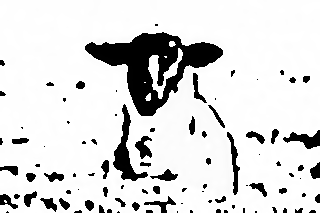

In [ ]:
kernel = log_filter(15, 3)
conv_image = convolve_image(img, kernel, convolver=cv2_convolver)
pil_conv_image = get_image_array(conv_image, True)

We now compare with the LoG by `scipy`.

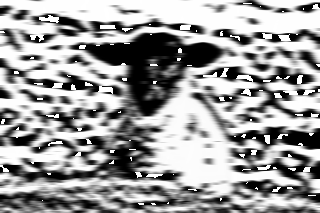

In [ ]:
conv_image = log_scipy(img, 3, 15)
pil_conv_image = get_image_array(conv_image, True)

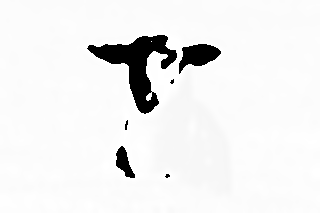

In [ ]:
kernel = dog_filter(15, 3, 1)
conv_image = convolve_image(img, kernel, convolver=cv2_convolver)
pil_conv_image = get_image_array(conv_image, True)

## Convolution
We now manually define our convolver for 2D-images.

First, since the convolution is not applied by multiplying with the kernel matrix in a ... # todo why swap_matrix

In [ ]:
def swap_matrix(mat: np.ndarray):
  if len(mat.shape) != 2:
    raise ValueError("'mat' parameter must be a np.ndarray with shape of size 2")
  m, n = mat.shape[-2:]
  for i in range(m):
    mat[i, :] = mat[i, ::-1]
  for j in range(n):
    mat[:, j] = mat[::-1, j]
  return mat

In [ ]:
mat = np.random.randn(4, 4)
mat

array([[-0.95652505,  0.35588733,  0.49514117,  0.30040119],
       [ 1.20590518,  1.31229796,  0.51060863, -0.82809356],
       [ 0.11707701, -0.44610197,  0.11065572,  0.86171403],
       [ 2.3759573 ,  1.70739618,  1.38503998, -0.62736506]])

In [ ]:
swap_matrix(mat)
mat

array([[-0.62736506,  1.38503998,  1.70739618,  2.3759573 ],
       [ 0.86171403,  0.11065572, -0.44610197,  0.11707701],
       [-0.82809356,  0.51060863,  1.31229796,  1.20590518],
       [ 0.30040119,  0.49514117,  0.35588733, -0.95652505]])

In [ ]:
def compute_padding():
  """
  Computes convolution with padding.
  """
  ...

In [ ]:
def get_offsets(k):
  left_width_offset = up_height_offset = k // 2 # According to our construction of kernel
  right_width_offset = down_height_offset = k - (k // 2) # Including center
  return left_width_offset, right_width_offset, up_height_offset, down_height_offset

In [ ]:
def get_kernel_indexes(kernel, m, n, k):
  left_width_offset, right_width_offset, up_height_offset, down_height_offset = get_offsets(k)
  # kernel_row_start = 0 if (i - left_width_offset >= 0) else (left_width_offset - i)
  kernel_row_start = max(0, left_width_offset - i)
  kernel_row_end = left_width_offset + min(right_width_offset, n - i)
  # kernel_row_end = k if right_width_offset <= n - i else left_width_offset + n - i
  kernel_column_start = max(0, up_height_offset - j)
  kernel_column_end = up_height_offset + min(down_height_offset, m - j)
  # kernel_column_end = k if j + down_height_offset <= m else up_height_offset + m - j
  return kernel_row_start, kernel_row_end, kernel_column_start, kernel_column_end

In [ ]:
def get_image_indexes(i, j, m, n, k):
  left_width_offset, right_width_offset, up_height_offset, down_height_offset = get_offsets(k)
  image_row_start = max(0, i - left_width_offset)
  image_row_end = min(n, i + right_width_offset)
  image_column_start = max(0, j - up_height_offset)
  image_column_end = min(m, j + down_height_offset)
  return image_row_start, image_row_end, image_column_start, image_column_end

In [ ]:
def convolve2d(image: np.ndarray, kernel: np.ndarray, pad_value=0.0):
  """
  Applies a 2d-convolution between the given image and
  the given kernel with padding.
  :param image: Image to convolve as numpy array.
  :param kernel: Kernel to use for convolution as 2d numpy array.
  :param pad_value: Value to use for padding. Defaults to 0.
  :return: Convolved image as numpy array.
  """
  # First, copy kernel matrix to swap
  swap_kernel = kernel.copy()
  swap_matrix(swap_kernel)
  
  output = np.full(image.shape, pad_value, dtype=kernel.dtype)
  m, n = kernel.shape[-2:]  # m rows, n columns
  k = len(kernel)  # size of the kernel matrix
  for i in range(m):
    for j in range(n):
      # Extract submatrix from kernel for applying convolution
      kernel_row_start, kernel_row_end, kernel_column_start, kernel_column_end = get_kernel_indexes(kernel, m, n, k)
      kernel_submatrix = swap_kernel[kernel_row_start:kernel_row_end, kernel_column_start:kernel_column_end]
      # Now extract submatrix from image
      image_row_start, image_row_end, image_column_start, image_column_end = get_image_indexes(i, j, m, n, k)
      image_submatrix = image[image_row_start:image_row_end, image_column_start:image_column_end]
      # TODO Check if image_row_end, kernel_row_end etc are correct or need +1
      # Now multiply the submatrices element-wise to get the current output item
      output[i, j] = np.sum(image_submatrix * kernel_submatrix)
  return output


### TODO:
1. Check correctness of the LoG filter as implemented above;
2. Write my 2D convolver (including swaps of raws and columns of array);
3. Check against known convolvers (scipy, opencv);
4. Implement the local maximum finder
5. Implement the multiple-scale algorithm with maxima and packaging
in one image (with associated info on sigma etc for each point)
6. Plot the blobs with radius $\sigma\sqrt{2}$
7. Take 3-4 images for showing results

In [ ]:
%timeit cv2.filter2D(np.asarray(img), -1, kernel)
%timeit convolve2d(np.asarray(img), kernel)

1.58 ms ± 287 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
71.9 ms ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
